# Importar librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -q ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 865.6/865.6 kB 18.4 MB/s eta 0:00:00


In [ ]:
import os
import shutil
import json
from ultralytics import YOLO

## Ajustes Iniciales

In [ ]:
# @title
# Nombre del alumno
student_name = "santiago_ferrero"

# Ruta al archivo de pesos
model_path = "/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).pt"   #para probar el otro modelo se debe cambiar el nombre aca

# Ruta al directorio que contiene las imagenes
imgs_dir = "/content/drive/MyDrive/00.alumnes_practico/data/eval/images/val/"

In [ ]:
model = YOLO(model_path)

In [ ]:
# Ruta al directorio de destino de las detecciones
base_dir = "/content/drive/MyDrive/00.alumnes_practico/data/out"
dets_dir = os.path.join(base_dir, student_name)

# Reestablecimiento del directorio de destino (eliminacion)
if os.path.exists(dets_dir):
    shutil.rmtree(dets_dir)

os.makedirs(dets_dir)

## Inferencia

Se genera un archivo con las detecciones en formato YOLOv5, donde cada línea contiene:
 cls, xc, yx, w, h, c

* **cls**: número de índice de la clase

* **xc**: coordenada x al centro de la caja delimitadora (bbox)

* **yx**: coordenada y al centro de la caja delimitadora (bbox)

* **w**: ancho de la caja delimitadora

* **h**: alto de la caja delimitadora

* **c**: certeza del modelo sobre la clasificacíon (confidence)


Se llama al método result.save_txt(file_name, save_conf=True)


In [ ]:
import os

def get_txt_filename(file_path: str) -> str:
    img_filename = os.path.basename(file_path)
    base_filename = os.path.splitext(img_filename)[0]
    return base_filename + ".txt"

def read_card(img_path: str) -> tuple:
    cards_readed = set()
    total_cartas = 0
    cards = {"E": [], "C": [], "B": [], "O": []}
    results = model.predict(img_path, agnostic_nms=True)

    for result in results:
        result = result.cpu()
        result.save_txt(os.path.join(dets_dir, get_txt_filename(result.path)), save_conf=True)
        total_cartas = len(result.boxes.cls)

        if total_cartas < 1 or total_cartas > 3:
            print("La cantidad de cartas no permite calcular envido")
            return None, total_cartas, results

        for i in range(total_cartas):
            carta = result.names[int(result.boxes.cls[i])]
            cards_readed.add(carta)
            if carta[0] in ["8", "9", "J", "SKIP", "SSKIP", "SSSKIP"]:
                print(f"Carta no válida para cantar envido: {carta}")
                return None, total_cartas, results
            print(carta)
            cards[carta[-1]].append(int(carta[:-1]))

    if len(cards_readed) != total_cartas:
        print(f"Se han detectado cartas iguales: {cards}")
        #return None, total_cartas, results

    return cards, total_cartas, results

def calc_envido(envido: dict) -> tuple:
    """Calcula los puntos del envido"""
    puntos = {"E": 0, "C": 0, "B": 0, "O": 0}

    for dibujo, valores in envido.items():
        if valores:
            valores = [v if v < 10 else 0 for v in valores]
            sorted_numbers = sorted(valores, reverse=True)
            puntos[dibujo] = sorted_numbers[0]
            if len(valores) > 1:
                puntos[dibujo] += sorted_numbers[1] + 20

    max_value = max(puntos.values())
    if max_value == 0:
        max_key = 'N/A'
    else:
        max_key = max(puntos, key=puntos.get)

    return max_key, max_value

In [ ]:
# Lista para almacenar el resultado del cálculo de envido de cada imagen
card_ds_file = {}

# Realizamos la inferencia imagen por imagen
for img_path in os.listdir(imgs_dir):
    cards, n_cards, _ = read_card(os.path.join(imgs_dir, img_path))

    if cards:
        figure, points = calc_envido(cards)
        card_ds_file[img_path] = {
            "total_cards": n_cards,
            "cards": cards,
            "points": points,
            "figure": figure,
        }
    else:
        card_ds_file[img_path] = {
            "total_cards": 0,
            "cards": [],
            "points": 0,
            "figure": "N/A",
        }


6O
3O
7E
La cantidad de cartas no permite calcular envido
1E
Carta no válida para cantar envido: 8C
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
2C
5E
1O
Carta no válida para cantar envido: 8B
3C
4O
10E
La cantidad de cartas no permite calcular envido
5E
3B
5O
5O
Se han detectado cartas iguales: {'E': [], 'C': [], 'B': [], 'O': [5, 5]}
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
6B
7E
3E
La cantidad de cartas no permite calcular envido
7E
5B
La cantidad de cartas no permite calcular envido
7B
La cantidad de cartas no permite calcular envido
La cantidad de cartas no permite calcular envido
2B
3B
7E


## Escritura del archivo envido.json

In [ ]:
with open("/content/drive/MyDrive/00.alumnes_practico/data/eval/gt_envido.json", "w") as jf:
    json.dump(card_ds_file, jf, indent=4)

# Muestra de inferencias

Se puede ver la deteccion echa imagen por imagen y tambien esta detallado antes de cada foto, las clases detectadas, las coordenadas de su bounding box y la confianza.

Clase: 6O, Box: (330.70, 1929.06, 910.79, 3088.42), Confianza: 0.47
Clase: 3O, Box: (1146.86, 1761.06, 2027.70, 3184.51), Confianza: 0.35


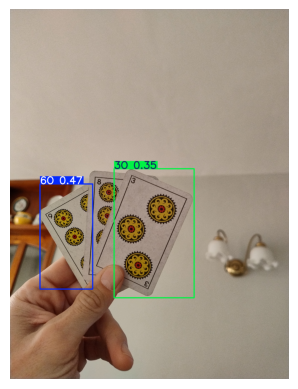

Clase: 7E, Box: (1405.77, 1506.42, 2076.96, 2374.51), Confianza: 0.48


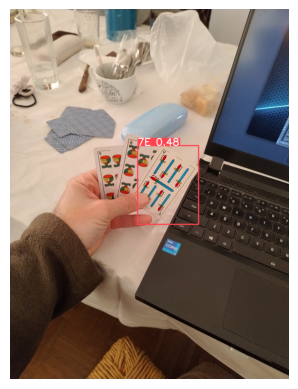

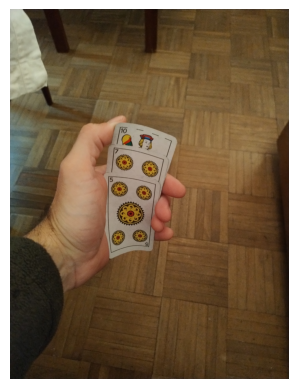

Clase: 1E, Box: (1315.86, 2116.90, 1875.94, 3115.66), Confianza: 0.87
Clase: 8C, Box: (802.90, 2095.39, 1355.36, 2966.96), Confianza: 0.25


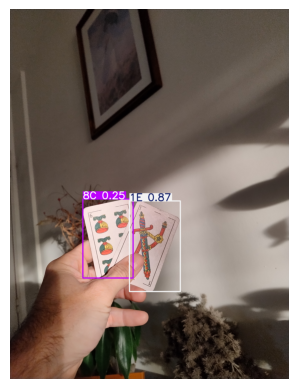

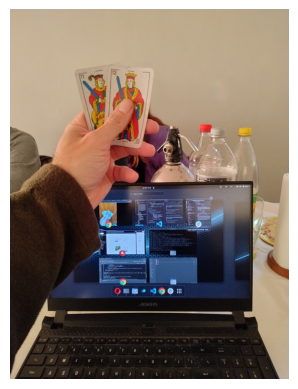

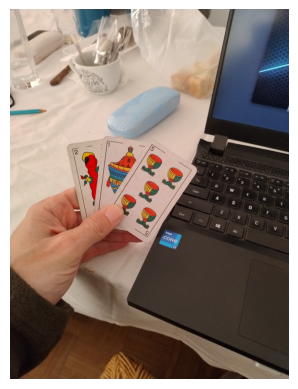

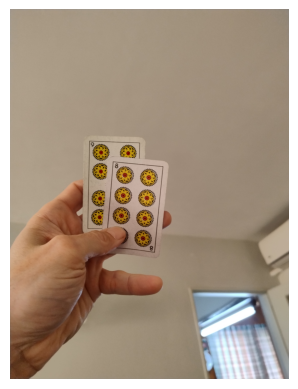

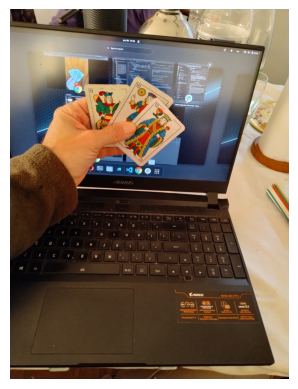

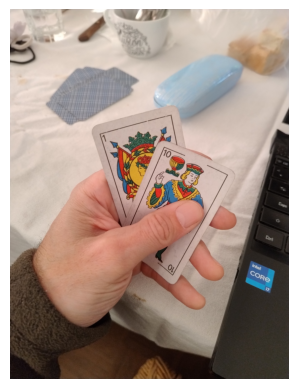

Clase: 2C, Box: (872.36, 0.10, 2104.51, 1383.21), Confianza: 0.72


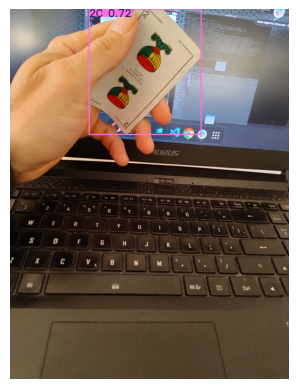

Clase: 5E, Box: (1593.83, 1152.40, 2375.05, 2169.51), Confianza: 0.52
Clase: 1O, Box: (1007.98, 1157.67, 1668.88, 2093.07), Confianza: 0.39


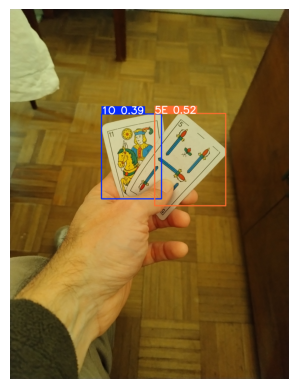

Clase: 8B, Box: (655.74, 1491.62, 1298.27, 2612.16), Confianza: 0.83


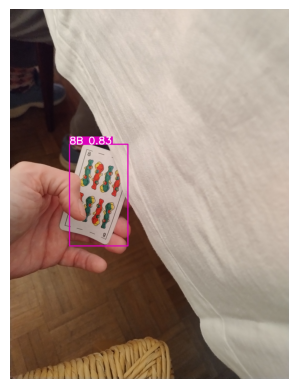

Clase: 3C, Box: (164.51, 1042.87, 747.23, 1850.44), Confianza: 0.30


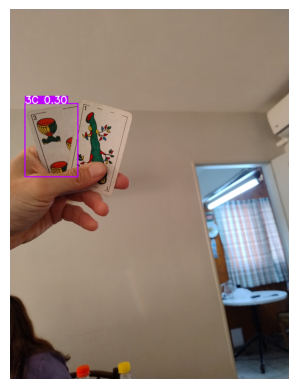

Clase: 4O, Box: (1076.60, 901.56, 1780.93, 2054.76), Confianza: 0.83
Clase: 10E, Box: (1656.68, 855.32, 2578.90, 2210.81), Confianza: 0.38


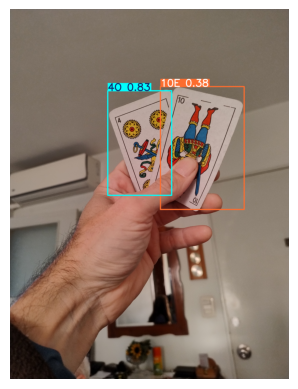

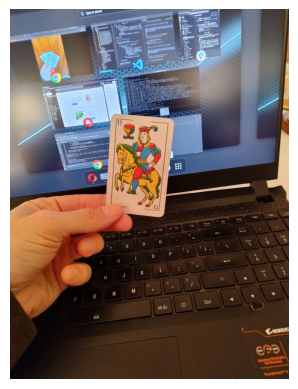

Clase: 5E, Box: (448.73, 1757.12, 1084.79, 2761.95), Confianza: 0.30
Clase: 3B, Box: (1296.97, 2033.87, 2410.41, 3153.97), Confianza: 0.27


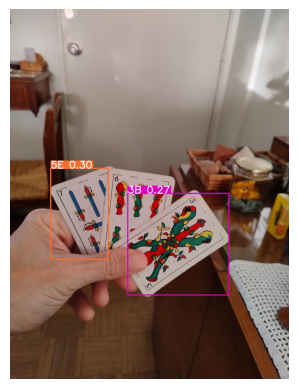

Clase: 5O, Box: (881.97, 2407.98, 1425.05, 3156.35), Confianza: 0.42
Clase: 5O, Box: (906.83, 2159.68, 1533.48, 2462.82), Confianza: 0.32


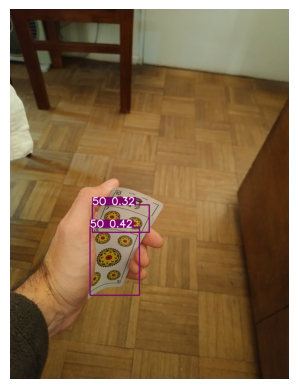

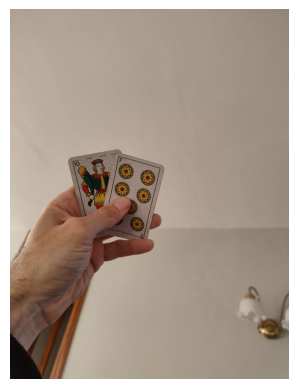

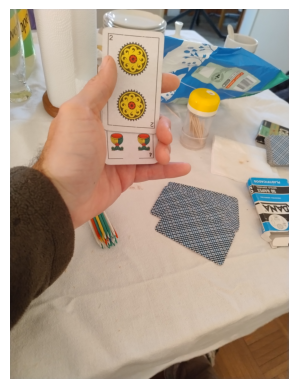

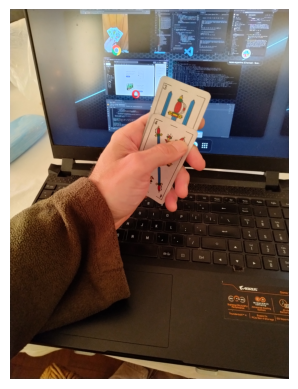

Clase: 6B, Box: (1491.33, 1243.22, 2282.87, 2418.90), Confianza: 0.68
Clase: 7E, Box: (1066.76, 1206.69, 1633.76, 2467.70), Confianza: 0.66


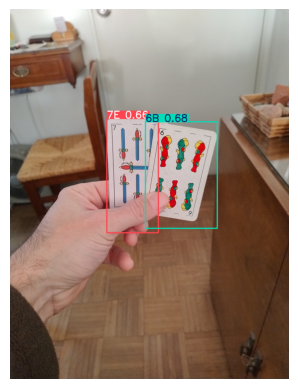

Clase: 3E, Box: (1102.70, 1064.15, 1653.30, 1946.32), Confianza: 0.87


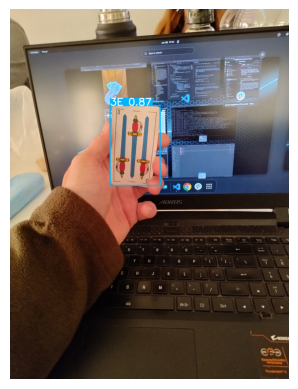

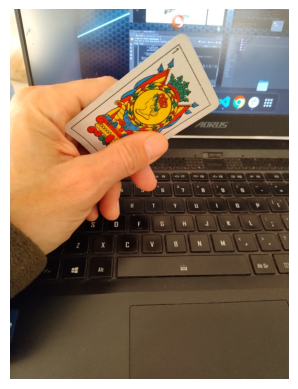

Clase: 7E, Box: (1478.80, 1899.74, 2191.78, 3010.12), Confianza: 0.67


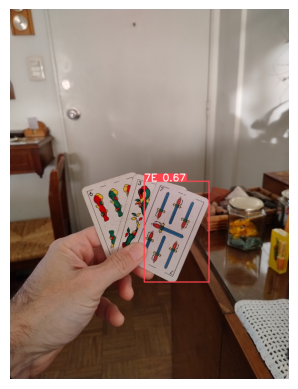

Clase: 5B, Box: (1476.69, 966.99, 2977.50, 2324.23), Confianza: 0.84


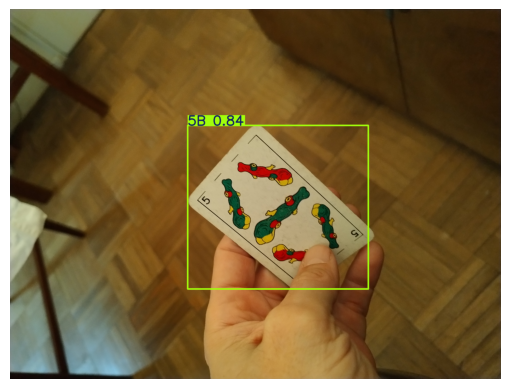

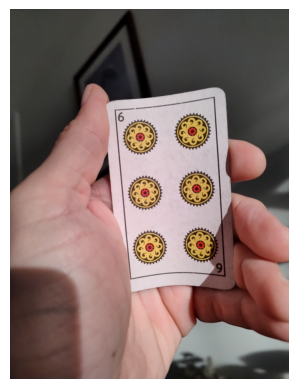

Clase: 7B, Box: (707.89, 1178.06, 1347.38, 2185.75), Confianza: 0.68


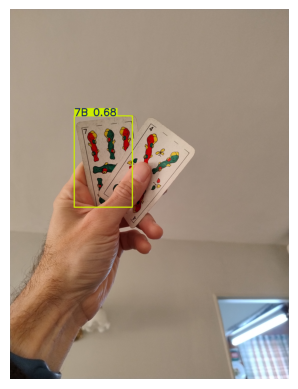

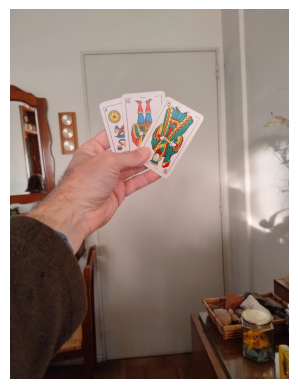

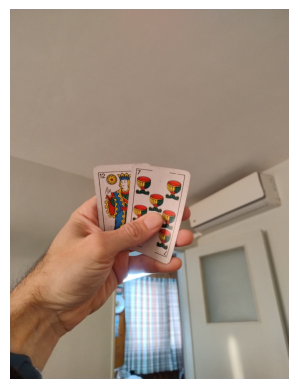

Clase: 2B, Box: (1154.28, 2457.49, 2209.76, 4061.00), Confianza: 0.91


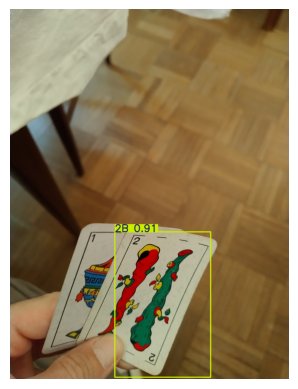

Clase: 3B, Box: (839.32, 1075.14, 1532.95, 2227.05), Confianza: 0.67


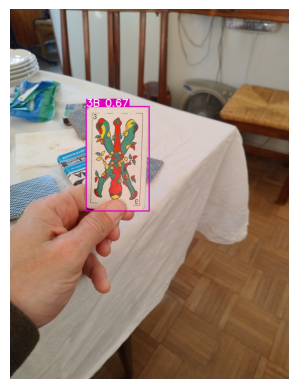

Clase: 7E, Box: (1518.46, 1064.61, 2434.69, 1762.89), Confianza: 0.27


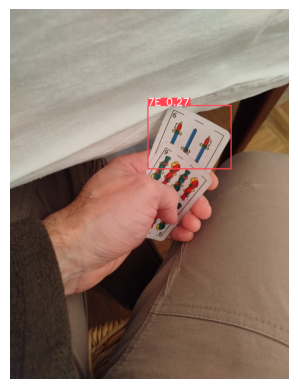

In [ ]:
# Importamos las librerías a utilizar
import cv2
from ultralytics import YOLO
from IPython.display import Image
import matplotlib.pyplot as plt

# Realizamos la inferencia imagen por imagen
for img_path in os.listdir(imgs_dir):
  # Perform inference
  source_img = cv2.imread(os.path.join(imgs_dir, img_path))
  #source_img = os.path.join(images_dir, img_path)
  results = model(source_img, agnostic_nms=True)

  # Iteramos sobre los boung boxes obtenidos
  for box in results[0].boxes:
      # Extrayendo los datos del tensor
      x1, y1, x2, y2, confidence, cls = box.data[0]

      # Obteniendo el nombre de la clase
      class_name = model.names[int(cls)]

      # Imprimir los resultados en un formato legible
      print(f"Clase: {class_name}, Box: ({x1:.2f}, {y1:.2f}, {x2:.2f}, {y2:.2f}), Confianza: {confidence:.2f}")

  # Visualize the results on the frame
  annotated_frame = results[0].plot()

  plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
  plt.axis('off')
  plt.show()

# Optimización de modelos

Mido el tiempo que demora en hacer la inferencia de todas las imagenes, utilizando cpu y utilizando gpu. Luego otimizo el modelo utilizando la libreria TensorRT, y calculo el tiempo.

In [ ]:
len(imgs_dir)

64

### Velocidad de inferencia con CPU

In [ ]:
import time
import os

# counters
inference_total = 0
preprocess_total = 0
postprocess_total = 0

# save start time
start_time = time.perf_counter()

model.cpu()

# Realizamos la inferencia imagen por imagen
for img_path in os.listdir(imgs_dir):
  results = model.predict(imgs_dir + img_path, agnostic_nms=True, verbose=False)
  inference_total += results[0].speed['inference']
  preprocess_total += results[0].speed['preprocess']
  postprocess_total += results[0].speed['postprocess']

# calculate elapsed time
elapsed_time = time.perf_counter() - start_time

# calculate average time for inference
average_time = inference_total / len(imgs_dir)
print("Average inference time:", average_time, "ms")
print("Average preprocess time:", preprocess_total / len(imgs_dir), "ms")
print("Average postprocess time:", postprocess_total / len(imgs_dir), "ms")
print("Average total process time per frame:", elapsed_time / len(imgs_dir) * 100, "ms")

# Frames per second
fps = len(imgs_dir) / elapsed_time
print("FPS:", fps)

Average inference time: 55.66425248980522 ms
Average preprocess time: 1.5106648206710815 ms
Average postprocess time: 0.37424638867378235 ms
Average total process time per frame: 14.783410132812591 ms
FPS: 6.76433915460713


### Velocidad de inferencia con GPU

In [ ]:
# Check available GPU
!nvidia-smi

Mon Aug 12 23:59:47 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0              29W /  70W |    389MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import time
import os

# counters
inference_total = 0
preprocess_total = 0
postprocess_total = 0

model = YOLO('/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).pt')

# save start time
start_time = time.perf_counter()

# Realizamos la inferencia imagen por imagen
for img_path in os.listdir(imgs_dir):
  results = model.predict(imgs_dir + img_path, agnostic_nms=True, verbose=False)
  inference_total += results[0].speed['inference']
  preprocess_total += results[0].speed['preprocess']
  postprocess_total += results[0].speed['postprocess']

# calculate elapsed time
elapsed_time = time.perf_counter() - start_time

# calculate average time for inference
average_time = inference_total / len(imgs_dir)
print("Average inference time:", average_time, "ms")
print("Average preprocess time:", preprocess_total / len(imgs_dir), "ms")
print("Average postprocess time:", postprocess_total / len(imgs_dir), "ms")
print("Average total process time per frame:", elapsed_time / len(imgs_dir) * 100, "ms")

# Frames per second
fps = len(imgs_dir) / elapsed_time
print("FPS:", fps)

Average inference time: 4.349134862422943 ms
Average preprocess time: 1.4302879571914673 ms
Average postprocess time: 0.5609504878520966 ms
Average total process time per frame: 10.368809423437497 ms
FPS: 9.644308803087993


### Velocidad de inferencia con GPU + TensorRT

Preparamos el entorno de trabajo

In [ ]:
%%capture
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install ultralytics nvidia-tensorrt

In [ ]:
from ultralytics import YOLO
import numpy as np
np.bool = np.bool_  # Fix por version de numpy de Colab

model = YOLO('/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).pt')
# Export the model to TensorRT format
model.export(format="engine")

WARNING ⚠️ TensorRT requires GPU export, automatically assigning device=0
Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3,015,788 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 56, 5376) (17.6 MB)
requirements: Ultralytics requirement ['onnx>=1.12.0'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 235.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 12.9s, installed 1 package: ['onnx>=1.12.0']
requirements: ⚠️ Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.16.2 opset 17...
ONNX: export success ✅ 15.1s, saved as '/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).onnx' (11.7 MB)

TensorRT: starting export with TensorRT 10.3.0...
TensorRT: input "imag

'/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).engine'

In [ ]:
# Load the exported TensorRT model
tensorrt_model = YOLO(f"/content/drive/MyDrive/00.alumnes_practico/model/weights/last (10).engine", task='detect')

In [ ]:
import time
import os

# counters
inference_total = 0
preprocess_total = 0
postprocess_total = 0

# save start time
start_time = time.perf_counter()

# Realizamos la inferencia imagen por imagen
for img_path in os.listdir(imgs_dir):
  results = tensorrt_model.predict(imgs_dir + img_path, agnostic_nms=True, verbose=False)
  inference_total += results[0].speed['inference']
  preprocess_total += results[0].speed['preprocess']
  postprocess_total += results[0].speed['postprocess']

# calculate elapsed time
elapsed_time = time.perf_counter() - start_time

# calculate average time for inference
average_time = inference_total / len(imgs_dir)
print("Average inference time:", average_time, "ms")
print("Average preprocess time:", preprocess_total / len(imgs_dir), "ms")
print("Average postprocess time:", postprocess_total / len(imgs_dir), "ms")
print("Average total process time per frame:", elapsed_time / len(imgs_dir) * 100, "ms")

# Frames per second
fps = len(imgs_dir) / elapsed_time
print("FPS:", fps)

Average inference time: 2.425745129585266 ms
Average preprocess time: 1.9018277525901794 ms
Average postprocess time: 0.41590631008148193 ms
Average total process time per frame: 8.672178390624907 ms
FPS: 11.531128108262324
